# Offset Rademacher Complexity

<font color='green'> In this practical session, we introduce the idea of localized Rademacher complexity measures through a simple example of offset Rademacher complexity. Our main objectives are the following:
</font>
- <font color='green'>revisiting the symmetrization and contraction techniques leading to Rademacher complexity upper bounds on the estimation error;</font>
- <font color='green'>understanding why Rademacher complexity upper bounds may fail to capture the correct rate of convergence;</font>
- <font color='green'>gaining an intuitive understanding of ways to capture the correct rate.</font>

In the lectures, we have seen how the notion of Rademacher complexity can be used to provide upper bounds on the estimation error of learning algorithms aimed at minimizing the empirical risk. For simplicity, in this practical session, we will investigate a slightly easier problem of bounding the *expected* estimation error. The aim of this practical session is to demonstrate some of the limitations of Rademacher complexity upper bound
as well as potential ways to resolve them.

We now recall the general setup of a statistical learning problem. Let $Z_{1}^{n} = (Z_{1}, \dots, Z_{n})$ denote an i.i.d. sample of $n$ input-output pairs $Z_{i} = (X_{i}, Y_{i}) \in \mathcal{X} \times \mathcal{Y}$ sampled from some unknown distribution $P$. Let $\mathcal{A}$ denote some function class of interest mapping $\mathcal{X}$ to $\mathcal{Y}$. Denote any empirical risk minimizer among the functions in $\mathcal{A}$ by
$$
  A = A^{(ERM)} \in \mathrm{argmin}_{a \in \mathcal{A}} R(a),\quad\text{where}\quad
  R(a) = \frac{1}{n} \sum_{i=1}^{n}\ell(a, Z_{i})
$$
for some loss function $\ell : \mathcal{A} \times \mathcal{Y} \to [0, \infty)$.

Let $\Omega_{1}, \dots, \Omega_{n}$ denote $n$ i.i.d. Rademacher random variables (i.e., independent symmetric $\{-1, +1\}$ valued random variables).
The *empirical Rademacher complexity* of the function class $\mathcal{A}$ conditionally on the observed covariates
$X_{1} = x_{1}, \dots, X_{n} = x_{n}$ is defined by
$$
    \mathrm{Rad}(\mathcal{A} \circ \{x_{1}, \dots, x_{n}\})
    = \mathbf{E}_{\Omega_{1}^{n}}\left[
      \sup_{a \in \mathcal{A}} \left\{
        \frac{1}{n}\sum_{i=1}^{n}\Omega_{i}a(x_{i})
      \right\}
    \right].
$$

If the loss function $\ell$ is $\gamma$-Lipschitz in the sense that
$$
  \forall a, a' \in \mathcal{A} \text{ and } \forall z \in \mathcal{Z} = \mathcal{X} \times \mathcal{Y}\text{ it holds that } 
  \left|\ell(a, z) - \ell(a', z)\right| \leq \gamma \left|a(x) - a'(x)\right|,
$$
then the expected estimation error of any empirical risk minimizer $A$ can be upper bounded by
\begin{align}
  \mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - \inf_{a \in \mathcal{A}} r(a)
  \right]
  &\leq 2 \mathbf{E}_{Z_{1}^{n}}\left[
      \mathbf{E}_{\Omega_{1}^{n}}\left[
          \sup_{a \in \mathcal{A}}\left\{
            \frac{1}{n}\sum_{i=1}^{n}\Omega_{i}\ell(a, Z_{i}) 
          \right\}
          \bigg\vert Z_{1}, \dots, Z_{n}
      \right]
  \right]
  \\
  &\leq 
  2\gamma \mathbf{E}_{X_{1}^{n}}\left[
      \mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\}
  \right],
\end{align}
where the final step follows via Ledoux-Talagrand contraction inequality.
Before revisiting the proof leading to the above expected estimation error upper bound, we turn to the next section where we are asked to compute the Rademacher complexity in the special case when $\mathcal{A}$ is a class of linear functions bounded in $\ell_{2}$ norm.

---

**Setup**


>In the rest of this practical session, we fix the following setup:
>\begin{align}
    \mathcal{X} &= \{x \in \mathbb{R}^{d} : \|x\|_{2} \leq 1\}, \\
    \mathcal{Y} &= [-2, 2], \\
    \mathcal{A} &= \{a_{w}(\cdot) = \langle w, \cdot \rangle : w \in \mathbb{R}^{d}, \|w\|_{2} \leq 1 \}, \\
    \ell(a_{w}, z) &= (\langle w, x \rangle - y)^{2}.
\end{align}
Notice that within the above setp, the quadratic loss is $6$-Lipschitz (i.e. $\gamma = 6$), and in particular, for any data generating distribution $P$ supported on $\mathcal{X} \times \mathcal{Y}$ we have
$$
  \mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - \inf_{a \in \mathcal{A}} r(a)
  \right]
  \leq 
  12 \mathbf{E}_{X_{1}^{n}}\left[
      \mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\}
  \right].
$$
><font color='green'>**All of the results to follow will be stated in force of the setup outlined above. We have chosen the above setting to provide a simple example of an easy learning problem for which Rademacher complexity measure fails to capture the correct estimation error convergence rate. Analyzing this example will allow us to better understand why localization of Rademacher complexities is necessary to obtain tight upper bounds on the estimation error.**</font>
>
---

## Rademacher Complexity of Bounded Linear Function

In Exercise 1, we will compute an upper bound on the Rademacher complexity of linear predictors. To empirically verify whether the proved upper bound is tight, we will first implement a function that allows us to obtain Monte Carlo estimates of $\mathbf{E}_{X_{1}^{n}}[\mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\})]$.
For our simulations, we fix the marginal distribution of the covariates to be uniform over the unit sphere.

In [1]:
import numpy as np # For manimpulating arrays.
from matplotlib import pyplot as plt # For potting.
from sklearn.linear_model import LinearRegression # For computing A.

The below function implements the sampling of random covariate vectors.

In [2]:
def sample_from_P_X(n, d):
  """ Returns an n \times d numpy whose i-th row is equal to a d-dimensional
  vector, sampled uniformly from the unit sphere. """
  X = np.random.normal(loc=0, scale=1, size=(n,d))
  l2_norms = np.sqrt(np.sum(X**2, axis=1)).reshape(-1,1)
  return X / l2_norms

The below function implements sampling Rademacher random variables.

In [3]:
def sample_Omegas(n):
  """ Returns an n dimensional numpy array whose i-th element is equal to an
  independent sample of a Rademacher random variable. """
  return np.random.binomial(n=1, p=0.5, size=(n,))*2.0 - 1.0

We can now implement a function that returns Monte Carlo samples of $\mathbf{E}_{X_{1}^{n}}[\mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\})]$.

In [4]:
def sample_Rad(n, d):
  """ :n: Number of data points.
      :d: Dimension of the covariates.
      :returns: A tuple (w_opt, rad), where w_opt is a d-dimensional vector
        maximizing \frac{1}{n}\sum_{i=1}^{n} Omega_i * <w, X_i> and rad is 
        a 1-sample Monte Carlo estimate of E[Rad(A \circ {X_1, \dots, X_n})].
  """
  X = sample_from_P_X(n, d)
  Omega = sample_Omegas(n)
  # We now need to compute
  #  \sup_{w : ||w||_{2} \leq 1} \frac{1}{n} \sum_{i=1}^{n} Omega_i * <w, X_i>.
  sum_Omega_i_X_i = np.average(X * Omega.reshape(-1, 1), axis=0)
  sum_Omega_i_X_i_l2_norm = np.sqrt(np.sum(sum_Omega_i_X_i**2))
  # The optimum is attained by a unit vector perfectly aligned with
  # \sum_{i=1}^{n} Omega_i * X_i.
  w_opt = sum_Omega_i_X_i / sum_Omega_i_X_i_l2_norm
  return w_opt, sum_Omega_i_X_i_l2_norm

Below, we show how to use the `sample_Rad` function to empirically evaluate how
$\mathbf{E}_{X_{1}^{n}}[\mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\})]$ scales with respect to the sample size $n$. We fix the dimension $d=10$ in the below simulations.

Text(0, 0.5, '$\\log \\mathbf{E} \\mathrm{Rad}(\\mathcal{A} \\circ \\{X_{1}, \\dots, X_{n}\\})$')

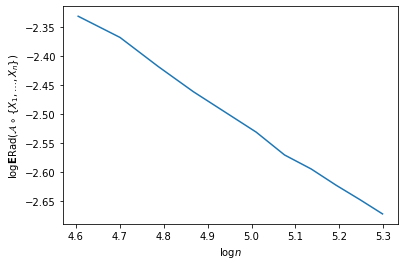

In [5]:
ns = np.arange(start=100, stop=201, step=10)
d = 10
n_monte_carlo_samples = 2500
rad_estimates = np.zeros(len(ns))

np.random.seed(0)
for idx, n in enumerate(ns):
  for _ in range(n_monte_carlo_samples):
    rad_estimates[idx] += sample_Rad(n, d)[1] / n_monte_carlo_samples

plt.plot(np.log(ns), np.log(rad_estimates))
plt.xlabel(r'$\log n$')
plt.ylabel(r'$\log \mathbf{E} \mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\})$')

The slope in the above generated plot is approximately equal to $-0.5$. This suggests that
$\mathbf{E}_{X_{1}^{n}}[\mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\}]$
scales as $O(1/\sqrt{n})$ (within our setup described at the beginning of this notebook). The next exercise asks you to prove this.

### Exercise 1

Consider the problem setup described in the introduction. Prove that for any dimension $d$ of covariate vectors we have
$$
  \mathbf{E}_{X_{1}^{n}}[
    \mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\})
  ] \leq \frac{1}{\sqrt{n}}.
$$

#### Hint

You may it helpful to recall [Cauchy-Schwarz](https://en.wikipedia.org/wiki/Cauchy%E2%80%93Schwarz_inequality) and [Jensen's](https://en.wikipedia.org/wiki/Jensen%27s_inequality) inequalities.

#### Solution

For any $x_{1}, \dots, x_{n} \in \mathcal{X}$ we have
\begin{align*}
  \mathrm{Rad}(\mathcal{A} \circ \{ x_{1}, \dots, x_{n} \})
  &= \mathbf{E}_{\Omega_{1}^{n}}\left[
    \sup_{w : \|w\| \leq 1} \left\{
      \frac{1}{n}\sum_{i=1}^{n}\Omega_{i} \langle w, x_{i} \rangle
    \right\}
  \right]
  \\
  &= \frac{1}{n} \mathbf{E}_{\Omega_{1}^{n}}\left[
    \sup_{w : \|w\| \leq 1} \left\{
      \left\langle w, \sum_{i=1}^{n} \Omega_{i} x_{i} \right\rangle
    \right\}
  \right]
  \\
  &\leq \frac{1}{n} \mathbf{E}_{\Omega_{1}^{n}}\left[
    \sup_{w : \|w\| \leq 1} \left\{
      \left\|w\right\|_{2}
      \left\| \sum_{i=1}^{n} \Omega_{i} x_{i} \right\|_{2}
    \right\}
  \right]
  &\text{by Cauchy-Schwarz inequality}
  \\
  &\leq \frac{1}{n} \mathbf{E}_{\Omega_{1}^{n}}\left[
      \left\| \sum_{i=1}^{n} \Omega_{i} x_{i} \right\|_{2}
  \right]
  \\
  &\leq \frac{1}{n}
      \sqrt{
        \mathbf{E}_{\Omega_{1}^{n}}\left[
        \left\| \sum_{i=1}^{n} \Omega_{i} x_{i} \right\|_{2}^{2}
        \right]
       }
  &\text{by Jensen's inequality}
  \\
  &= \frac{1}{n}
      \sqrt{
        \mathbf{E}_{\Omega_{1}^{n}}\left[
          \sum_{i,j} \Omega_{i}\Omega_{j} \langle x_{i}, x_{j}\rangle
        \right]
       }
  \\
  &= \frac{1}{n}
      \sqrt{
        \mathbf{E}_{\Omega_{1}^{n}}\left[
          \sum_{i} \Omega_{i}^{2} \langle x_{i}, x_{i}\rangle
        \right]
       }
  \\
  &= \frac{1}{n}
      \sqrt{
          \sum_{i} \|x_{i}\|_{2}^{2}
       }
  \\
  &\leq \frac{1}{n}
      \sqrt{
          \sum_{i} 1
       }
  \\
  &= \frac{1}{\sqrt{n}}.
\end{align*}

## Rademacher Complexity Upper Bounds on the Estimation Error

In the introduction, we have discussed that Rademacher complexity leads to the following upper bound on the expected estimation error (within the setup described at the beginning of this notebook):
$$
  \mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - \inf_{a \in \mathcal{A}} r(a)
  \right]
  \leq 
  12 \mathbf{E}_{X_{1}^{n}}\left[
      \mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\})
  \right].
$$
<font color='green'>**Let us now devise an experiment to verify how tight the above upper bound is; specifically, we want to find out if the left hand side of the above inequality indeed decreases as $1/\sqrt{n}$.**</font>

We will use the already implemented function `sample_from_P_X` to sample the covariate vectors. Conditionally on the covariate vectors, we will generate the
labels as follows:
$$
  Y \vert X = x \sim \langle w^{\star}, x \rangle + \underbrace{\mathrm{Uniform}[-1, 1]}_{\text{noise}},
  \text{ where } w^{\star} = \frac{1}{2}(1/\sqrt{d}, \dots, 1/\sqrt{d})^{\mathsf{T}}.
$$
Notice that the above choice of $P$ ensures that $Y \in [-2, 2]$ with probability $1$.
The following function implements the conditional distribution of the response variable $Y$.

In [6]:
def sample_Y_given_X(X, w_star):
  """ :X: An n \times d numpy array with the i-th row equal to the i-th
        covariate vector X_i.
      :return: An n \times 1 numpy array, with the i-th element equal to
        a sample <w_star, X_i> + Uniform[-1, 1].
  """
  n = X.shape[0]
  return X @ w_star + np.random.uniform(low=-1.0, high=1.0, size=(n, 1))

In the next cell we implement a function for generating datasets to be used in our simulations.


In [7]:
def get_w_star(d):
  """ Returns the parameter w* which represents the optimal linear function. """
  return np.ones((d, 1)) * 0.5 / np.sqrt(d)

def generate_dataset(n, d):
  """ Generates a dataset to be used in linear regression simulations, sampled
  from the distribution described in the text above.
    :n: Number of data points.
    :d: Dimension of the covariates.
    :returns: The dataset X, y, where X is a numpy array of shape n \times d
      with the i-th row equal to X_i and y is a numpy array of shape n \times 1
      with the i-th element equal to Y_i.
  """
  X = sample_from_P_X(n, d)
  w_star = get_w_star(d)
  y = sample_Y_given_X(X, w_star)
  return X, y

We now turn to the next exercise, which asks us to verify how well Rademacher complexities capture the scale of true expected estimation error.

### Exercise 2

Recall that $A$ denotes any empirical risk minimizer in the set $\mathcal{A}$ (see the beginning of this notebook for the exact setup).
- Implement a function `sample_estimation_error` for computing Monte Carlo estimates of the expected estimation error
$$
  \mathbf{E}_{Z_{1}^{n}}[r(A) - \inf_{a \in \mathcal{A}} r(a)]
  = \mathbf{E}_{Z_{1}^{n}}[r(A) - r(\langle w^{\star}, \cdot \rangle)]
$$
- For the range of sample sizes given by the variable `ns` (defined above) and
$d = 10$, generate a log-log plot of the estimated expected estimation error.
How fast does the expected estimation error decay with respect to the sample size $n$?

*Remark.* Due to the choice of our data generating distribution, for large enough sample sizes $n$ empirical risk minimization over $\mathcal{A}$ will coincide (with high probability) with empirical risk minimization over the unconstrained space $\{\langle w, \cdot \rangle : w \in \mathbb{R}^{d}\}$.
Hence, in this exercise, you may compute any empirical risk minimizer over the unconstrained space (i.e., the ordinary least squares (OLS) estimator). You may compute the OLS estimator either directly or via the following package:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.

In [8]:
def sample_estimation_error(n, d):
  """ :n: Number of data points.
      :d: Dimension of the covariates.
      :returns: A tuple (A, estimation_error), where A is a d-dimensional vector
        maximizing the empirical risk over \mathcal{A}, and estimation_error is
        equal to r(A) - r(<w*, .>), i.e., a 1-sample Monte Carlo estimate of
        E[r(A) - r(<w*,.>)].
  """
  ##############################################################################
  # Exercise 2. Fill in the below code.
  X, y = generate_dataset(n, d)
  reg = LinearRegression(fit_intercept=False)
  reg.fit(X, y)
  A = reg.coef_.reshape(-1, 1)
  # The estimation error is equal to
  # (A - w*)^t * E[XX^t] (A - w*) = ||A-w*||_2^2 * 1/d.
  w_star = get_w_star(d)
  estimation_error = np.average((A - w_star)**2)
  return A, estimation_error
  ##############################################################################

#### Solution

The function `sample_estimation_error` may be implemented as follows:
```
def sample_estimation_error(n, d):
  X, y = generate_dataset(n, d)
  reg = LinearRegression(fit_intercept=False)
  reg.fit(X, y)
  A = reg.coef_.reshape(-1, 1)
  # The estimation error is equal to
  # (A - w*)^t * E[XX^t] (A - w*) = ||A-w*||_2^2 * 1/d.
  w_star = get_w_star(d)
  estimation_error = np.average((A - w_star)**2)
  return A, estimation_error
```

We can now generate Monte Carlo estimates of the expected estimation error and compare them with Rademacher complexity upper bounds.

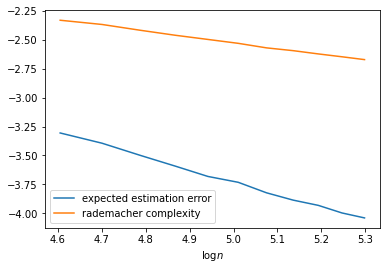

In [9]:
d = 10
n_monte_carlo_samples = 2500
estimation_error_estimates = np.zeros(len(ns))

np.random.seed(0)
for idx, n in enumerate(ns):
  for _ in range(n_monte_carlo_samples):
    estimation_error_estimates[idx] += \
      sample_estimation_error(n, d)[1] / n_monte_carlo_samples

plt.plot(np.log(ns), np.log(estimation_error_estimates))
plt.plot(np.log(ns), np.log(rad_estimates))
plt.xlabel(r'$\log n$')
plt.legend(['expected estimation error', 'rademacher complexity'])

<font color='green'>**From the above plot, we see that the expected estimation error appears to decay as $O(1/n)$, while the Rademacher complexity decays only as $O(1/\sqrt{n})$.
We conclude that Rademacher complexity fails to capture the true behaviour in the above example.**</font>

### Exercise 3

In Exercise 2, we have found a mismatch between the true estimation error and the upper bounds offered by Rademacher complexities. To gain some intuition as to what went wrong, perform the following simulation:
  1. For visualization purposes, fix $d = 2$.
  2. Plot a disc of radius 1, representing the function class $\mathcal{A}$.
  3. For a fixed value of the sample size $n$:
    - Using the function `sample_estimation_error`, mark 100 samples of $A$ on the generated plot (one sample for one realization of a dataset $Z_{1}^{n}$);
    - Using the function `sample_Rad`, mark 100 samples of a function optimizing the supremum in the computation of Rademacher complexity (one sample for one realization of $X_{1}^{n}, \Omega_{1}^{n}$).
  4. Repeat step $3$ for different sample sizes $n$. What do you observe?


#### Solution

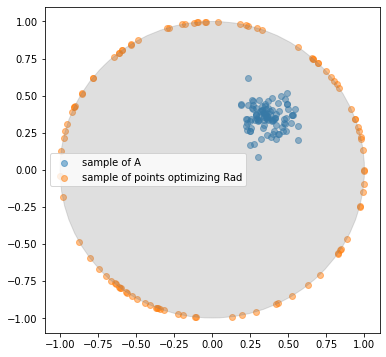

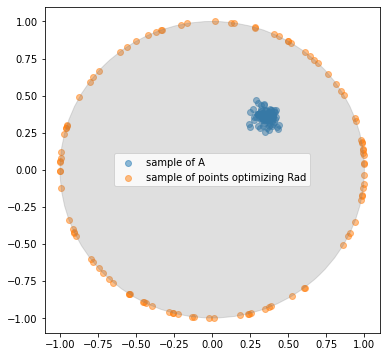

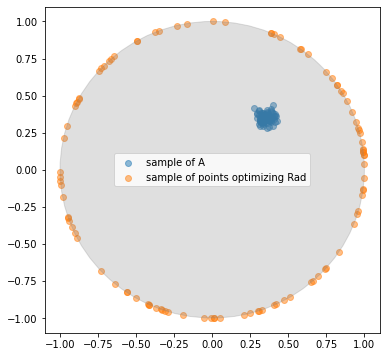

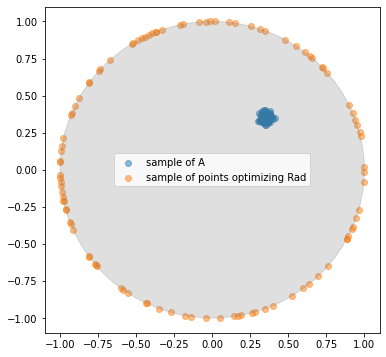

In [10]:
def get_figure_with_shaded_disc():
  """ Returns a figure with a plotted disc of radius 1. """
  fig, ax = plt.subplots()
  fig.set_size_inches(6, 6)
  ax.set_ylim(-1.1, 1.1)
  ax.set_xlim(-1.1, 1.1)
  
  # Mark the function space \mathcal{A} by a gray disc.
  function_space = plt.Circle((0,0), 1.0, color='gray', alpha=0.25)
  ax.add_patch(function_space)

  return fig, ax

def scatter_plot_random_points(ax, n_points, random_functions, colors, labels):
  """ A helper function for step 3 of Exercise 3.
      :ax: Axis object for plotting.
      :n_points: Number of randomly drawn points to plot.
      :random_function: A list of random functions, each taking no arguments
        and returning a randomly generated point from some distribution.
      :colors: A list of colors, one color for each random function.
      :labels: A list of labels to be displayed in the legend, one for each
        random function.
  """ 
  point_handles = []
  for (random_function, color) in zip(random_functions, colors):
    for _ in range(n_points):
      point = random_function()
      point_handle = ax.scatter(point[0], point[1], color=color, alpha=0.5)
    point_handles.append(point_handle)
  ax.legend(point_handles, labels)

for n in [100, 400, 800, 1600]:
  fig, ax = get_figure_with_shaded_disc()
  sample_A_lambda = lambda : sample_estimation_error(n, 2)[0]
  sample_Rad_lambda = lambda : sample_Rad(n, 2)[0]
  scatter_plot_random_points(ax=ax, n_points=100,
                            random_functions=[sample_A_lambda,
                                              sample_Rad_lambda],
                            colors=['C0','C1'],
                            labels=['sample of A',
                                    'sample of points optimizing Rad'])

In the plots generated above, we observe that as $n$ increases, the randomly drawn empirical risk minimizers $A$ tend to concentrate closer and closer to the population risk minimizer $w^{\star}$. <font color='green'>**Thus, the effective search space of the empirical risk minimization algorithm decreases as the sample size increases**</font>, because functions far away from the population risk minimizer become less likely to be empirical risk minimizers.

On the other hand, the supremum inside the definition of Rademacher complexity is always attained by some function on the boundary of $\mathcal{A}$. <font color='green'>**Thus,
Rademacher complexity does not take into account the fact that the output of empirical risk minimization algorithm gets better with increasing sample size $n$**</font>, which in turn leads to suboptimally scaling upper bounds.


## Revisiting the Proof of Rademacher Complexity Upper Bound

In order to fix the problem depicted in the simulations of Exercise 3, let us first revisit the steps taken to arrive at the Rademacher complexity upper bound on the expected estimation error. Below, we assume that the population risk minimizer among $\mathcal{A}$ exists and is denoted by $a^{\star}$. We proceed as follows:

\begin{align*}
  &\mathbf{E}_{Z_{1}^{n}}\left[r(A) - r(a^{\star})\right]
  \\
  &=\mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - R(A)
    + R(A) - R(a^{\star})
    + R(a^{\star}) - r(a^{\star})
  \right]
  \\
  &=\mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - R(A)
    \right]
    + 
    \mathbf{E}_{Z_{1}^{n}}\left[
      R(A) - R(a^{\star})
    \right]
    + \underbrace{\mathbf{E}_{Z_{1}^{n}}\left[
      R(a^{\star}) - r(a^{\star})
   \right]}_{=0}
  \\
  &=\mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - R(A)
    \right]
    + 
    \underbrace{
    \mathbf{E}_{Z_{1}^{n}}\left[
      R(A) - R(a^{\star})
    \right]
    }_{\leq 0 \text{ since }A\text{ is an ERM}}
  \\
  &\leq\mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - R(A)
    \right]
  \\
  &\leq\mathbf{E}_{Z_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}}\left\{
      r(a) - R(a)
    \right\}
    \right]
  \\
  &=\mathbf{E}_{Z_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}}\left\{
      r(a) - R(a)
    \right\}
    \right]
  \\
  &=\mathbf{E}_{Z_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}}\left\{
      \mathbf{E}_{(Z')_{1}^{n}}[R'(a)] - R(a)
    \right\}
    \right]
  &\text{introducing an independent copy }(Z')_{1}^{n}\text{ of }Z_{1}^{n}
  \text{ and letting }R'(a) = \frac{1}{n}\sum_{i=1}^{n}\ell(a, Z_{i}')
  \\
  &\leq \mathbf{E}_{Z_{1}^{n}, (Z')_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}}\left\{
      R'(a) - R(a)
    \right\}
    \right]
  \\
  &= \mathbf{E}_{Z_{1}^{n}, (Z')_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}}\left\{
      \frac{1}{n}\sum_{i=1}^{n}(\ell(a, Z'_{i}) - \ell(a, Z_{i}))
    \right\}
    \right]
  \\
  &= \mathbf{E}_{Z_{1}^{n}, (Z')_{1}^{n}, \Omega_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}}\left\{
      \frac{1}{n}\sum_{i=1}^{n}\Omega_{i}(\ell(a, Z'_{i}) - \ell(a, Z_{i}))
    \right\}
    \right]
  &\text{by symmetry}
  \\
  &\leq \mathbf{E}_{Z_{1}^{n}, (Z')_{1}^{n}, \Omega_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}}\left\{
      \frac{1}{n}\sum_{i=1}^{n}\Omega_{i}\ell(a, Z'_{i})
    \right\}
    + \sup_{a \in \mathcal{A}}\left\{
      \frac{1}{n}\sum_{i=1}^{n}-\Omega_{i} \ell(a, Z_{i})
    \right\}
    \right]
  \\
  &= 2\mathbf{E}_{Z_{1}^{n}, \Omega_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}}\left\{
      \frac{1}{n}\sum_{i=1}^{n} \Omega_{i} \ell(a, Z_{i})
    \right\}
    \right]
  \\
  &= 2\mathbf{E}_{Z_{1}^{n}}\bigg[
      \underbrace{
        \mathbf{E}_{\Omega_{1}^{n}}\left[
        \sup_{a \in \mathcal{A}}\left\{
          \frac{1}{n}\sum_{i=1}^{n} \Omega_{i} \ell(a, Z_{i})
        \right\}
        \bigg\vert
        Z_{1},\dots,Z_{n}
        \right]
      }_{
       = \mathrm{Rad}(\mathcal{L} \circ \{Z_{1}, \dots, Z_{n}\})
       = \mathrm{Rad}(\{
           (\ell(a, Z_{1}), \dots, \ell(a, Z_{n}))^{\mathsf{T}}
           \in \mathbb{R}^{n}
           : a \in \mathcal{A}
         \})
      \text{ by definition}
      }
    \bigg]
  \\
  &= 2 \mathbf{E}_{Z_{1}^{n}}\left[
    \mathrm{Rad}(\mathcal{L} \circ \{Z_{1}, \dots, Z_{n}\}) 
    \big\vert
    Z_{1},\dots,Z_{n}
  \right]
  \\
  &\leq 2\gamma \mathbf{E}_{X_{1}^{n}}\left[
    \mathrm{Rad}(\mathcal{A} \circ \{X_{1}, \dots, X_{n}\}) 
    \big\vert
    X_{1},\dots,X_{n}
  \right]
  &\text{by Ledoux-Talagrand contraction principle for }\gamma\text{-Lipschitz losses,}
\end{align*}

<font color='green'>**Notice that the key steps in the above proof are symmetrization (introducing the Rademacher random variables) and contraction. It turns out that a refined offset Rademacher complexity upper bound, which will be introduced in the next section, can be obtained via a more careful application of the same techniques.**</font>

### Exercise 4

Consider the linear regression setup described at the beginning of this notebook. When the above chain of derivations is applied to such setting,
our previously performed simulations suggest that the left-hand side (i.e., the expected estimation error) is of order $O(1/n)$, while the right-hand side (i.e., the Radmacher complexity upper bound) is of order $\Omega(1/\sqrt{n})$. 

By way of a simulation or otherwise, find the first inequality/suboptimal step that "loses" the rate (i.e., the first inequality that upper bounds a term of order $1/n$ by a term of order $1/\sqrt{n}$).

#### Solution

The second inequality below already leads to a suboptimally scaling upper bound of order $\Omega(1/\sqrt{n})$
\begin{align*}
  \mathbf{E}_{Z_{1}^{n}}\left[r(A) - r(a^{\star})\right]
  &\leq\mathbf{E}_{Z_{1}^{n}}\big[
    r(A) - R(A)
  \big]
  \\
  &\leq \mathbf{E}_{Z_{1}^{n}}\big[
    \sup_{a \in \mathcal{A}} \left\{r(a) - R(a)\right\}
  \big].
\end{align*}
We empirically verify this claim by running the simulations below.


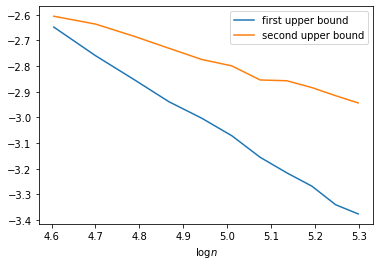

In [11]:
def sample_first_upper_bound(n, d):
  """ Returns a 1-Sample Monte Carlo estimate of E[r(A) - R(A)]. """
  X, y = generate_dataset(n, d)
  reg = LinearRegression(fit_intercept=False)
  reg.fit(X, y)
  A = reg.coef_.reshape(-1, 1)
  # Compute the population risk r(A).
  # r(A) = ||A - w*||_{2}^{2} + Variance(noise).
  w_star = get_w_star(d)
  r_A = np.average((A - w_star)**2) + 1.0/3.0
  # Compute the empirical risk R(A).
  R_A = np.average((X @ A - y)**2)
  return r_A - R_A


def sample_second_upper_bound(n, d):
  """ Returns a **lower bound** on a 1-Sample Monte Carlo estimate of
      E[\sup_{a \in \mathcal{A}} {r(a) - R(a)}]. """
  # Instead of computing the supremum over \mathcal{A}, we will generate
  # some random vectors w on the unit sphere and compute the maximum over
  # our random draws. This will serve as a lower bound for the supremum term.
  X, y = generate_dataset(n, d)
  supremum_term = 0 # Initialize the supremum term to 0, attained by a = 0.

  n_samples = 30
  w_star = get_w_star(d)
  for _ in range(n_samples):
    # Generate a random vector on a unit sphere.
    a = sample_from_P_X(n=1, d=d).reshape(-1, 1)
    # Compute generalization error r(a) - R(a).
    # Note that r(a) = ||a - w*||_{2}^{2} + Variance(noise).
    r_a = np.average((a - w_star)**2) + 1.0/3.0
    R_a = np.average((X @ a - y)**2)
    generalization_error = r_a - R_a
    if generalization_error > supremum_term:
      # Update the supremum estimate.
      supremum_term = generalization_error

  return supremum_term


# We can now compute Monte Carlo estimates of the upper bounds obtained
# via the first two inequalities.
d = 10
n_monte_carlo_samples = 2500
first_step_estimates = np.zeros(len(ns))
second_step_estimates = np.zeros(len(ns))

np.random.seed(0)
for idx, n in enumerate(ns):
  for _ in range(n_monte_carlo_samples):
    first_step_estimates[idx] += \
      sample_first_upper_bound(n, d) / n_monte_carlo_samples
    second_step_estimates[idx] += \
      sample_second_upper_bound(n, d) / n_monte_carlo_samples

plt.plot(np.log(ns), np.log(first_step_estimates))
plt.plot(np.log(ns), np.log(second_step_estimates))
plt.xlabel(r'$\log n$')
plt.legend(['first upper bound', 'second upper bound'])

## Localization via Offset Rademacher Complexities

Recall that all of the below is stated in force of the setup described in the introduction (specifically, in what follows, it is important that the loss $\ell$ is quadratic and the function class $\mathcal{A}$ is convex).

In Exercise 4, we have found that in the development of Rademacher complexity upper bound on expected estimation error, the step that upper bounds $r(A) - R(A)$ by $\sup_{a \in \mathcal{A}} \{r(a) - R(a)\}$ results in suboptimal upper bounds. We have also visualized in Exercise 3 that the Rademacher complexity upper bounds on the above supremum are always attained at the boundary of the set $\mathcal{A}$, thus ignoring the fact that empirical risk minimization gets better with increasing sample size. <font color='green'>**In this section, we will confront this issue directly by introducing additional terms inside the supremum that will force the maximizers to stay close to the optimal function $a^{\star}$.**</font>

The localization idea that we will now introduce is due to *Liang, Rakhlin and Sridharan [2015]*, however, the more general idea of localization has been known long before; see the bibliographic remarks section for further details.
We begin our analysis as before, via the following identity:
$$
  \mathbf{E}_{Z_{1}^{n}}\left[r(A) - r(a^{\star})\right]
  =\mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - R(A)
    + R(A) - R(a^{\star})
    + R(a^{\star}) - r(a^{\star})
  \right]. \tag{1}
$$
<font color='green'>**This time, however, instead of using the upper bound $R(A) - R(a^{\star}) \leq 0$, which follows from the fact that $A$ minimizes the empirical risk, we will
use the refined upper bound**</font>
$$
  R(A) - R(a^{\star}) \leq -\|A - a^{\star}\|_{n}^{2}
  = -\frac{1}{n}\sum_{i=1}^{n} \left(A(X_{i}) - a^{\star}(X_{i})\right)^{2}.
$$
We omit the proof of the above bound, which follows from the fact that 
the quadratic loss function as well as the function class $\mathcal{A}$ is convex. Combining the above bound with equation $(1)$ we have
\begin{align*}
  \mathbf{E}_{Z_{1}^{n}}\left[r(A) - r(a^{\star})\right]
  &\leq \mathbf{E}_{Z_{1}^{n}}\left[
    r(A) - r(a^{\star}) - (R(A) - R(a^{\star}))
    - \|A - a^{\star}\|_{n}^{2}
  \right]
  \\
  &\leq \mathbf{E}_{Z_{1}^{n}}\left[
    \sup_{a \in \mathcal{A}} \left\{
    r(a) - r(a^{\star}) - (R(a) - R(a^{\star}))
    - \|a - a^{\star}\|_{n}^{2}
    \right\}
  \right]. \tag{2}
\end{align*}
<font color='green'>**The crucial difference with the previously obtained bounds is that in the above expression, the negative term $-\|a - a^{\star}\|_{n}^{2}$ will force the supremum to be attained at some function that is close to $a^{\star}$, thus avoiding the behaviour observed in Exercise 3.**</font>

In a similar manner that we have obtained the Rademacher complexity upper bound on the estimation error in the previous section, using the symmetrization and contraction techniques upper bound $(2)$ can be further upper bounded, for some constants $c,c' > 0$ depending only on boundedness properties of $\mathcal{Y}$ and $\mathcal{A}$ and in independent of the sample size $n$:
\begin{align*}
  &c'\mathbf{E}_{X_{1}^{n}}\bigg[
   \mathbf{E}_{\Omega_{1}^{n}}\left[
     \sup_{a \in \mathcal{A}}\left\{
          \frac{1}{n} \sum_{i=1}^{n} \Omega_{i}(a(X_{i}) - a^{\star}(X_{i}))
          - c\|a - a^{\star}\|_{n}^{2}
       \right\}
     \bigg\vert X_{1}, \dots, X_{n} 
    \right]
  \bigg]
  \\
  &=c'\mathbf{E}_{X_{1}^{n}}\bigg[
   \mathbf{E}_{\Omega_{1}^{n}}\left[
     \sup_{a \in \mathcal{A} - a^{\star}}\left\{
          \frac{1}{n} \sum_{i=1}^{n} \Omega_{i}a(X_{i})
          - c\|a\|_{n}^{2}
       \right\}
     \bigg\vert X_{1}, \dots, X_{n} 
    \right]
  \bigg]
  &\text{where }\mathcal{A} - a^{\star} = \{a - a^{\star} : a \in \mathcal{A}\}.
\end{align*}
We will call the inner expectation the *empirical offset Rademacher complexity*:
$$
  \mathrm{OffsetRad}(c, (\mathcal{A} - a^{\star}) \circ \{x_{1}, \dots, x_{n}\})
  =
   \mathbf{E}_{\Omega_{1}^{n}}\left[
     \sup_{a \in \mathcal{A} - a^{\star}}\left\{
          \frac{1}{n} \sum_{i=1}^{n} \Omega_{i}a(X_{i})
          - c\|a\|_{n}^{2}
       \right\}
    \right].
$$
Putting everything together we arrive at the following upper bound on the expected estimation error:
$$
  \mathbf{E}_{Z_{1}^{n}}\left[r(A) - r(a^{\star})\right]
  \leq c' \mathbf{E}_{X_{1}^{n}}\left[
    \mathrm{OffsetRad}(c, (\mathcal{A} - a^{\star}) \circ \{X_{1}, \dots, X_{n}\})
    \big\vert
    X_{1},\dots,X_{n}
  \right].
$$
The omitted proof details can be found in the proof of Theorem 4 in the paper by [Liang, Rakhlin and Sridharan [2015]](http://proceedings.mlr.press/v40/Liang15.pdf).

### Exercise 5

Let $\mathcal{A}_{\mathbb{R}^{d}} = \{\langle w, \cdot \rangle : w \in \mathbb{R}^{d}\}$. Notice that since $\mathcal{A} \subseteq \mathcal{A}_{\mathbb{R}^{d}}$, for any $x_{1}, \dots, x_{n} \in \mathcal{X}$ we have
$$
      \mathrm{OffsetRad}(c, (\mathcal{A} - a^{\star}) \circ \{x_{1}, \dots, x_{n}\})
      \leq \mathrm{OffsetRad}(c, (\mathcal{A}_{\mathbb{R}^{d}} - a^{\star}) \circ \{x_{1}, \dots, x_{n}\}).
$$

- Fill in the implementation details of the function `sample_OffsetRad` defined in the next cell.
- Fix any $c > 0$. Using the function `sample_OffsetRad`, verify empirically that the offset Rademacher complexity
   $$
      \mathbf{E}_{X_{1}^{n}}\left[
      \mathrm{OffsetRad}(c, (\mathcal{A}_{\mathbb{R}^{d}} - a^{\star}) \circ \{X_{1}, \dots, X_{n}\})
      \big\vert
      X_{1},\dots,X_{n}
    \right]
   $$
   decays as $O(1/n)$.

   *Remark.* Within our problem setup, the offset Rademacher complexity scales as $O(d/n)$, but you are only asked to focus on the dependence with respect to the sample size $n$.


In [12]:
def sample_OffsetRad(n, d, c):
  """ An offset Rademacher complexity equivalent of the function sample_Rad.
      :n: Number of data points.
      :d: Dimension of the covariates.
      :c: A non-negative offset Rademacher complexity parameter.
      :returns: A tuple (w_opt, rad), where:
        - w_opt is a d-dimensional vector maximizing
          \frac{1}{n}\sum_{i=1}^{n} (Omega_i * <w - w*, X_i> - c<w - w*, X_i>^2)
          with w ranging over all of R^{d};
        - offset_rad is a 1-sample Monte Carlo estimate of
          E[OffsetRad(c, (A_{R^d} - a*) \circ {X_1, \dots, X_n})].
  """
  X = sample_from_P_X(n, d)
  Omega = sample_Omegas(n)
  w_star = np.ones(d) * 0.5 / np.sqrt(d)
  ##############################################################################
  # Exercise 5. Fill in the missing implementation details below.
  b = np.average(X * Omega.reshape(-1, 1), axis=0).reshape(-1, 1)
  Sigma = np.transpose(X) @ X / n
  Sigma_inverse = np.linalg.inv(Sigma)
  w_opt = w_star + Sigma_inverse @ b / (2.0 * c)
  offset_rad = np.transpose(b) @ Sigma_inverse @ b / (4.0 * c) 
  return w_opt, offset_rad
  ##############################################################################

#### Solution

In the implementation of the function `sample_OffsetRad` we are asked to maximize $f : \mathbb{R}^{d} \to \mathbb{R}$ defined as
$$
  f(w) = \left\langle w, \underbrace{\frac{1}{n}\sum_{i=1}^{n}\Omega_{i}X_{i}}_{= b}\right\rangle
          - c(w - w^{\star})^{\mathsf{T}}
          \underbrace{\left(\frac{1}{n}\sum_{i=1}^{n}X_{i}X_{i}^{\mathsf{T}}\right)}_{= \widehat{\Sigma}}(w - w^{\star})
$$
over $w \in \mathbb{R}^{d}$. Differentiating with respect to $w$, we find that the optimal value is attained at (assuming invertibility of $\widehat{\Sigma}$):
$$
  w_{\mathrm{opt}} = w^{\star} + \frac{1}{2c}\widehat{\Sigma}^{-1}b.
$$
Plugging in $w_{\mathrm{opt}}$ into $f$ we obtain
$$
  \sup_{w \in \mathbb{R}^{d}} f(w) = f(w_{\mathrm{opt}}) = \frac{1}{4c}b^{\mathsf{T}}\widehat{\Sigma}^{-1}b.
$$
Using the above computations, the function `sample_OffsetRad` can be implemented as follows:
```
def sample_OffsetRad(n, d, c):
  X = sample_from_P_X(n, d)
  Omega = sample_Omegas(n)
  w_star = np.ones(d) * 0.5 / np.sqrt(d)
  b = np.average(X * Omega.reshape(-1, 1), axis=0).reshape(-1, 1)
  Sigma = np.transpose(X) @ X / n
  Sigma_inverse = np.linalg.inv(Sigma)
  w_opt = w_star + Sigma_inverse @ b / (2.0 * c)
  offset_rad = np.transpose(b) @ Sigma_inverse @ b / (4.0 * c) 
  return w_opt, offset_rad
```

We can now verify that the offset Rademacher complexity decays as $O(1/n)$.

Text(0, 0.5, '$\\log \\mathbf{E} \\mathrm{OffsetRad}(c, (\\mathcal{A}_{\\mathbb{R}^{d}} - a^{\\star}) \\circ \\{X_{1}, \\dots, X_{n}\\})$')

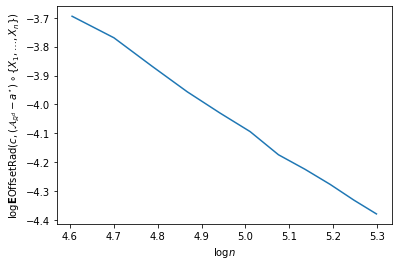

In [13]:
ns = np.arange(start=100, stop=201, step=10)
d = 10
n_monte_carlo_samples = 2500
offset_rad_estimates = np.zeros(len(ns))

np.random.seed(0)
for idx, n in enumerate(ns):
  for _ in range(n_monte_carlo_samples):
    offset_rad_estimates[idx] += \
      sample_OffsetRad(n, d, 1)[1] / n_monte_carlo_samples

plt.plot(np.log(ns), np.log(offset_rad_estimates))
plt.xlabel(r'$\log n$')
plt.ylabel(r'$\log \mathbf{E} \mathrm{OffsetRad}(c, (\mathcal{A}_{\mathbb{R}^{d}} - a^{\star}) \circ \{X_{1}, \dots, X_{n}\})$')

### Exercise 6

Repeat the simulations performed in Exercise 3, this time with Rademacher complexity replaced by the offset Rademacher complexity defined above.

#### Solution

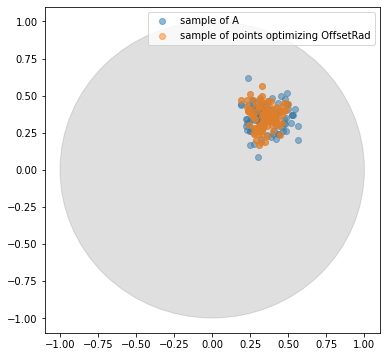

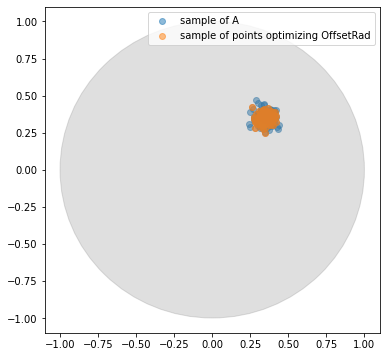

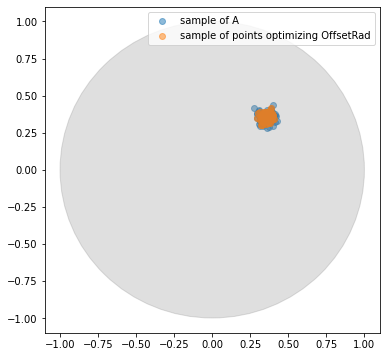

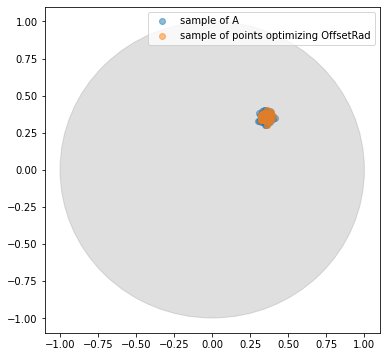

In [14]:
for n in [100, 400, 800, 1600]:
  fig, ax = get_figure_with_shaded_disc()
  sample_A_lambda = lambda : sample_estimation_error(n, 2)[0]
  sample_OffsetRad_lambda = lambda : sample_OffsetRad(n, 2, c=1.0)[0]
  scatter_plot_random_points(ax=ax, n_points=100,
                            random_functions=[sample_A_lambda,
                                              sample_OffsetRad_lambda],
                            colors=['C0','C1'],
                            labels=['sample of A',
                                    'sample of points optimizing OffsetRad'])

<font color='green'>**Observe that this time, in contrast to the results observed in Exercise 3, the effective domain of the sample points optimizing offset Rademacher complexity is decreasing with the increasing sample size $n$. This depicts the desired localization phenomenon.**</font>

## Bibliographic Remarks

In this practical session we have explored an example where Rademacher complexity measures without localization are insufficient to obtain correct bounds on the estimation error. In fact, it can be shown that global Rademacher complexities cannot yield bounds that decay faster than $1/\sqrt{n}$;
see, for example, *Bartlett and Mendelson [2006, Theorem 2.3]*.

Statistical performance of empirical risk minimization algorithms has been studied extensively from the empirical processes theory point of view, where the idea of localization is analogous to the fact that the correct rate of convergence is determined by a fixed point of the continuity modulus of the corresponding empirical process, rather than its supremum. For this point of view see *van de Geer [2000], Massart [2000]* and the references therein.
Localizing Rademacher complexities via an approach based on computing fixed points was developed, among other authors, by *Koltchinskii [2001], Bartlett, Bousquet, and Mendelson [2005], Koltchinskii [2006]*. See also the book by *Koltchinskii [2011]*.

When learning with the quadratic loss, the idea of localization via shifted empirical processes presented in this practical session was introduced by *Liang, Rakhlin, and Sridharan [2015]*. See also the work of *Zhivotovskiy and Hanneke [2018]* for related ideas applied to the setting of zero-one loss. Recent literature has also focused on obtaining complexity measures that can
be used in heavy-tailed scenarios; see *Mendelson [2015, 2020]*.


**References**

P. L. Bartlett and S. Mendelson. Empirical minimization. Probability theory and related fields, 135(3):311–334, 2006.

P. L. Bartlett, O. Bousquet, and S. Mendelson. Local rademacher complexities. The Annals of Statistics, 33(4):1497–1537, 2005.

V. Koltchinskii. Rademacher penalties and structural risk minimization. IEEE Transactions on Information Theory, 47(5):1902–1914, 2001.

V. Koltchinskii. Local rademacher complexities and oracle inequalities in risk minimization. The Annals of Statistics, 34(6):2593–2656, 2006. 

V. Koltchinskii. Oracle Inequalities in Empirical Risk Minimization and Sparse Recovery Problems: Ecole d’Eté de Probabilités de Saint-Flour XXXVIII-2008, volume 2033. Springer Science & Business Media, 2011.

T. Liang, A. Rakhlin, and K. Sridharan. Learning with square loss: Localization through offset rademacher complexity. In Conference on Learning Theory, pages 1260–1285, 2015.

P. Massart. Some applications of concentration inequalities to statistics. In Annales de la Faculté des sciences de Toulouse: Mathématiques, volume 9, pages 245–303, 2000.

S. Mendelson. Learning without concentration. J. ACM, 62(3), June 2015. ISSN 0004-5411. doi: 10.1145/2699439. URL https://doi.org/10.1145/2699439.

S. Mendelson. Extending the scope of the small-ball method. Studia Mathematica, pages 1–21, 2020.

S. van de Geer. Empirical Processes in M-estimation, volume 6. Cambridge university press, 2000.

N. Zhivotovskiy and S. Hanneke. Localization of vc classes: Beyond local rademacher complexities. Theoretical Computer Science, 742:27–49, 2018
